![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 9 - Tips and Tricks </center>
### <center> CutMix </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/MainResNet.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms

from torchinfo   import summary
from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/09_TipsAndTricks/DeepLearningFramework ./DeepLearningFramework

In [5]:
# from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR-10 dataset:

In [6]:
oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [7]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

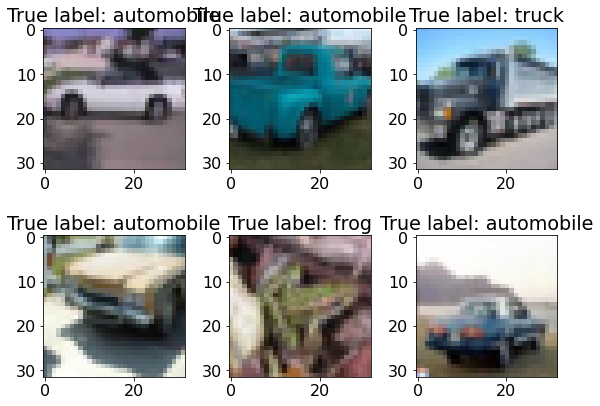

In [8]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow   (np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [9]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with augmentations:

In [10]:
oTrainTransform = transforms.Compose([
    transforms.AutoAugment         (policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor            (),
    transforms.Normalize           (vMean, vStd),
])

oTestTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd),
])

oTrainSet.transform = oTrainTransform
oTestSet .transform = oTestTransform

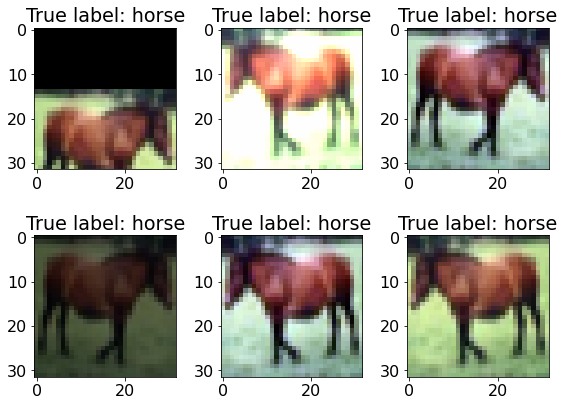

In [11]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 6))
for ax in fig.axes:
    idx   = 7
    mX, y = oTrainSet[idx]
#     mX, y = oTestSet [idx]
    mX    = np.transpose(mX.numpy(), (1,2,0))
    ax.imshow   (np.clip(mX * vStd[None,None,:] + vMean[None,None,:], 0, 1))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show        ()

#### Create data loaders:

In [12]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

mX, vY = next(iter(oTrainDL))

#### Define the model (ResNet):

In [13]:
def LeftBranch(C):
    oLeft = nn.Sequential(
        nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding=1, bias=False),
        nn.BatchNorm2d(C), nn.ReLU(), nn.Conv2d(C, C, 3, padding=1, bias=False)
    )
    return oLeft
               
def RightBranch(C):
    oRight = nn.Identity() #-- Identity

    return oRight

In [14]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super(ResBlock, self).__init__()
        
        self.oLeft  = LeftBranch(C)
        self.oRight = RightBranch(C)

    def forward(self, mX):
        mZ = self.oLeft(mX) + self.oRight(mX)
        return mZ
        
summary(ResBlock(64), (1, 64, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
ResBlock                                 --                        --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─BatchNorm2d: 2-1                  [1, 64, 56, 56]           128
│    └─ReLU: 2-2                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-3                       [1, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-4                  [1, 64, 56, 56]           128
│    └─ReLU: 2-5                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 64, 56, 56]           36,864
├─Identity: 1-2                          [1, 64, 56, 56]           --
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (M): 231.21
Input size (MB): 0.80
Forward/backward pass size (MB): 6.42
Params size (MB): 0.30
Estimated Total Size (MB): 7.52

In [15]:
def ModelWeightsInitialization(oModule):
    if isinstance(oModule, nn.Conv2d):
        nn.init.kaiming_normal_(oModule.weight.data)
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def GetModel():
    d      = 192
    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),
        nn.Conv2d(d, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),  nn.MaxPool2d(2),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(d, 10)
    )
    
    oModel.apply(ModelWeightsInitialization)
    
    return oModel

summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 3, 32, 32]          --
├─Conv2d: 1-2                            [128, 192, 32, 32]        5,184
├─BatchNorm2d: 1-3                       [128, 192, 32, 32]        384
├─ReLU: 1-4                              [128, 192, 32, 32]        --
├─Conv2d: 1-5                            [128, 192, 32, 32]        331,776
├─BatchNorm2d: 1-6                       [128, 192, 32, 32]        384
├─ReLU: 1-7                              [128, 192, 32, 32]        --
├─MaxPool2d: 1-8                         [128, 192, 16, 16]        --
├─ResBlock: 1-9                          [128, 192, 16, 16]        --
│    └─Sequential: 2-1                   [128, 192, 16, 16]        --
│    │    └─BatchNorm2d: 3-1             [128, 192, 16, 16]        384
│    │    └─ReLU: 3-2                    [128, 192, 16, 16]        --
│   

In [16]:
from DeepLearningFramework.Auxiliary import RandBox

def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #====================================================================================================#
            α    = 0.9
            λ    = np.random.beta(α, α)
            vIdx = torch.randperm(mX.shape[0], device=DEVICE)
            
            xLow, yLow, xHigh, yHigh      = RandBox(*mX.shape[2:], λ)
            mX[:,:,xLow:xHigh,yLow:yHigh] = mX[vIdx,:,xLow:xHigh,yLow:yHigh]
            λ                             = 1 - ((xHigh - xLow) * (yHigh - yLow) / (mX.shape[2] * mX.shape[3]))
            
            mZ   = oModel(mX)
            loss = λ * Loss(mZ, vY) + (1 - λ) * Loss(mZ, vY[vIdx])
            #====================================================================================================#
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [17]:
import time

from DeepLearningFramework.Metric import Accuracy

def TrainClassficationModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim, oScheduler=None):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    vLR        = np.full(0,       np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime                 = time.time()
        trainLoss, trainAcc, vLRi = Epoch(oModel, oTrainData, Loss, Accuracy, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valAcc,   _    = Epoch(oModel, oValData,   Loss, Accuracy,                     bTrain=False) #-- validate
        epochTime                 = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        vLR               = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load('BestModel.pt'))

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR

In [18]:
from DeepLearningFramework.Losses import LabelSmoothingLoss

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = LabelSmoothingLoss(10, ε=0.1)

In [19]:
nEpochs       = 250
nIter         = nEpochs * len(oTrainDL)

oModel        = GetModel               ().to(DEVICE)
oOptim        = optim.AdamW            (oModel.parameters(), lr=5e-5, betas=(0.9, 0.99), weight_decay=1e-2)
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-3, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 2.11492 | Val loss: 1.68648 | Train Accuracy: 0.2783 | Val Accuracy: 0.4802 | epoch time: 36.682 | <-- Checkpoint!
Epoch 001: | Train loss: 1.95612 | Val loss: 1.42642 | Train Accuracy: 0.3687 | Val Accuracy: 0.5934 | epoch time: 38.634 | <-- Checkpoint!
Epoch 002: | Train loss: 1.86643 | Val loss: 1.34999 | Train Accuracy: 0.4219 | Val Accuracy: 0.6441 | epoch time: 38.398 | <-- Checkpoint!
Epoch 003: | Train loss: 1.82969 | Val loss: 1.25453 | Train Accuracy: 0.4421 | Val Accuracy: 0.6911 | epoch time: 38.371 | <-- Checkpoint!
Epoch 004: | Train loss: 1.77168 | Val loss: 1.15843 | Train Accuracy: 0.4757 | Val Accuracy: 0.7325 | epoch time: 36.082 | <-- Checkpoint!
Epoch 005: | Train loss: 1.73376 | Val loss: 1.11465 | Train Accuracy: 0.4819 | Val Accuracy: 0.7619 | epoch time: 35.639 | <-- Checkpoint!
Epoch 006: | Train loss: 1.70102 | Val loss: 1.07525 | Train Accuracy: 0.5087 | Val Accuracy: 0.7723 | epoch time: 36.713 | <-- Checkpoint!
Epoch 007: | Train l

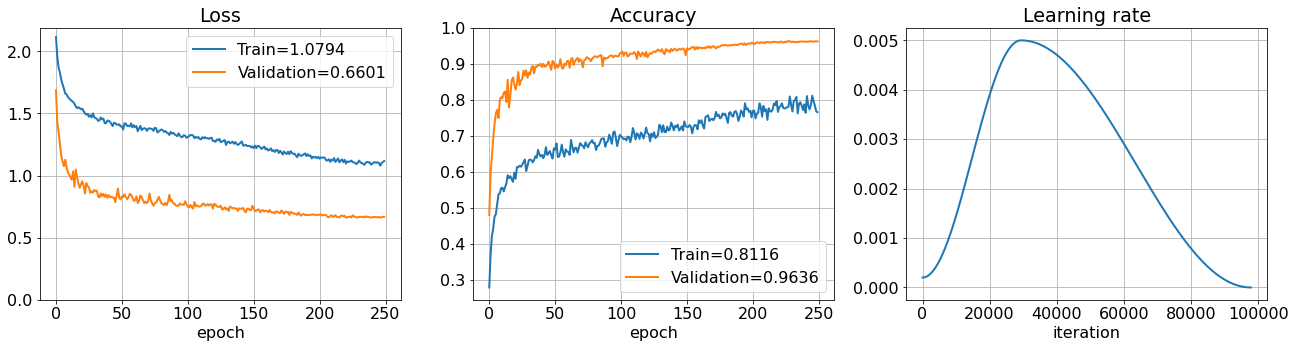

In [20]:
from DeepLearningFramework.Auxiliary import PlotHistory
    
PlotHistory(lHistory)
plt.show   ()